In [9]:
import numpy             as np
import matplotlib.pyplot as plt
import scipy.sparse      as sparse
import scipy.special     as sp

import hylife.utilitis_FEEC.bsplines             as bsp
import hylife.utilitis_FEEC.projectors_global    as proj_glob
import hylife.utilitis_FEEC.projectors_local     as proj_loc
import hylife.utilitis_FEEC.derivatives          as der
import hylife.utilitis_FEEC.evaluation           as eva
import hylife.geometry.mappings_analytical       as mapping
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D

In [10]:
Nel       = [16, 4, 4]              # mesh generation on logical domain
bc        = [True, True, True]      # boundary conditions (True: periodic, False: else)
p         = [3, 2, 2]               # spline degrees  


el_b      = [np.linspace(0., 1., Nel + 1) for Nel in Nel]                      # element boundaries
delta     = [1/Nel for Nel in Nel]                                             # element sizes
T         = [bsp.make_knots(el_b, p, bc) for el_b, p, bc in zip(el_b, p, bc)]  # knot vectors (for N functions)
t         = [T[1:-1] for T in T]                                               # reduced knot vectors (for D function)
NbaseN    = [Nel + p - bc*p for Nel, p, bc in zip(Nel, p, bc)]                 # number of basis functions (N functions)
NbaseD    = [NbaseN - (1 - bc) for NbaseN, bc in zip(NbaseN, bc)]              #number of basis functions (D functions)

kind_map = 1               #slab geometry
L_map    = [3., 2., 1.] #length of the simulation box 

args_map = kind_map, L_map #putting it together
rho_ini_phys = lambda x, y, z : np.sin(2*np.pi*x)

In [11]:
vx_ini_phys = lambda x, y, z : 1.
vy_ini_phys = lambda x, y, z : 0.
vz_ini_phys = lambda x, y, z : 0.

In [12]:
proj_glob = proj_glob.projectors_3d(T, p, bc)
proj_loc  = proj_loc.projectors_local_3d(T, p, bc)

In [13]:
def rho_ini(xi1_arr, xi2_arr, xi3_arr):
    n1, n2, n3 = xi1_arr.shape #xi1_arr Logical Coordinates (?)
    rho = np.empty((n1, n2, n3), dtype=float) # Returns numpy array of shape [n1,n2,n3] same fct as np.zeros
    for i1 in range(n1):
        for i2 in range(n2):
            for i3 in range(n3):
                idx = i1, i2, i3
                xi1 = xi1_arr[idx]
                xi2 = xi2_arr[idx]
                xi3 = xi3_arr[idx]
                x = mapping.f(xi1, xi2, xi3, *args_map, 1) #Analytic Mapping to slab Geometry
                y = mapping.f(xi1, xi2, xi3, *args_map, 2)
                z = mapping.f(xi1, xi2, xi3, *args_map, 3)
                rho[idx] = rho_ini_phys(x, y, z) * mapping.det_df(xi1, xi2, xi3, *args_map)
    return rho

In [14]:
def v1_ini(xi1, xi2_arr, xi3_arr):
    n2, n3 = xi2_arr.shape
    v1 = np.empty((n2, n3), dtype=float)
    for i2 in range(n2):
        for i3 in range(n3):
            idx = i2, i3
            
            xi2 = xi2_arr[idx]
            xi3 = xi3_arr[idx]

            x = mapping.f(xi1, xi2, xi3, *args_map, 1)
            y = mapping.f(xi1, xi2, xi3, *args_map, 2)
            z = mapping.f(xi1, xi2, xi3, *args_map, 3)

            df_11 = mapping.df(xi1, xi2, xi3, *args_map, 11)
            df_21 = mapping.df(xi1, xi2, xi3, *args_map, 21)
            df_31 = mapping.df(xi1, xi2, xi3, *args_map, 31)

            v1[idx] = vx_ini_phys(x, y, z) * df_11 + vy_ini_phys(x, y, z) * df_21 + vz_ini_phys(x, y, z) * df_31
    return v1

In [15]:
# proj_glob.assemble_V1()
# v1_coeff, v2_coeff, v3_coeff = proj_glob.PI_1([v1_ini, v2_ini, v3_ini])

In [16]:
proj_glob.assemble_V3()

In [17]:
rho_coeff = proj_glob.PI_3(rho_ini)

In [18]:
def v1_times_rho(xi1, xi2_arr, xi3_arr):
    n2, n3 = xi2_arr.shape
    fun = np.empty((n2, n3), dtype=float)
    
    xi2_arr1d = xi2_arr[:, 0]
    xi3_arr1d = xi3_arr[0, :]
    
    rho_h = eva.FEM_field_V3_3d(rho_coeff, [np.array([xi1]), xi2_arr1d, xi3_arr1d], T, p, bc)
    # v1_h, v2_h, v3_h = eva.FEM_field_V1_3d([v1_coeff, v2_coeff, v3_coeff], [xi1_arr1d, xi2_arr1d, xi3_arr1d], T, p, bc)
    
    fun = rho_h.reshape(n2, n3) * v1_ini(xi1, xi2_arr, xi3_arr)
    
    return fun

In [19]:
def v2_times_rho(xi1_arr, xi2, xi3_arr):
    n1, n3 = xi1_arr.shape
    fun = np.empty((n1, n3), dtype=float)
    
    xi1_arr1d = xi1_arr[:, 0]
    xi3_arr1d = xi3_arr[0, :]
    
    rho_h = eva.FEM_field_V3_3d(rho_coeff, [xi1_arr1d, np.array([xi2]), xi3_arr1d], T, p, bc)
    # v1_h, v2_h, v3_h = eva.FEM_field_V1_3d([v1_coeff, v2_coeff, v3_coeff], [xi1_arr1d, xi2_arr1d, xi3_arr1d], T, p, bc)
    
    fun = rho_h.reshape(n1, n3) * 0.
    
    return fun

In [20]:
def v3_times_rho(xi1_arr, xi2_arr, xi3):
    n1, n2 = xi1_arr.shape
    fun = np.empty((n1, n2), dtype=float)
    
    xi1_arr1d = xi1_arr[:, 0] #Take All the diferent coordinates in x1 as a 1d_array
    xi2_arr1d = xi2_arr[0, :] #Take All the diferent coordinates in x2 as a 1d_array
    # Third coordinate xi3 is the one that the function (rho*v)3 depends on
    rho_h = eva.FEM_field_V3_3d(rho_coeff, [xi1_arr1d, xi2_arr1d, np.array([xi3])], T, p, bc)
    # v1_h, v2_h, v3_h = eva.FEM_field_V1_3d([v1_coeff, v2_coeff, v3_coeff], [xi1_arr1d, xi2_arr1d, xi3_arr1d], T, p, bc)
    
    fun = rho_h.reshape(n1, n2) * 0.
    
    return fun

In [21]:
proj_glob.assemble_V2()

In [22]:
proj_loc.assemble_V2()

AttributeError: 'projectors_local_3d' object has no attribute 'assemble_V2'

In [23]:
rhov1_coeff, rhov2_coeff, rhov3_coeff = proj_glob.PI_2([v1_times_rho, v2_times_rho, v3_times_rho])#Project rho*v in V2  

In [24]:
derivatives = der.discrete_derivatives(T, p, bc)

DIV  = derivatives.DIV_3d()

In [25]:
DIV.todense() # Discrete Derivative Matrix

matrix([[-1.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0., -1.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0., -1., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ..., -1.,  1.,  0.],
        [ 0.,  0.,  0., ...,  0., -1.,  1.],
        [ 0.,  0.,  0., ...,  0.,  0., -1.]])

In [26]:
rho_t = -(DIV.dot(np.concatenate((rhov1_coeff.flatten(), rhov2_coeff.flatten(), rhov3_coeff.flatten())))).reshape(NbaseD[0], NbaseD[1], NbaseD[2])

<IPython.core.display.Javascript object>


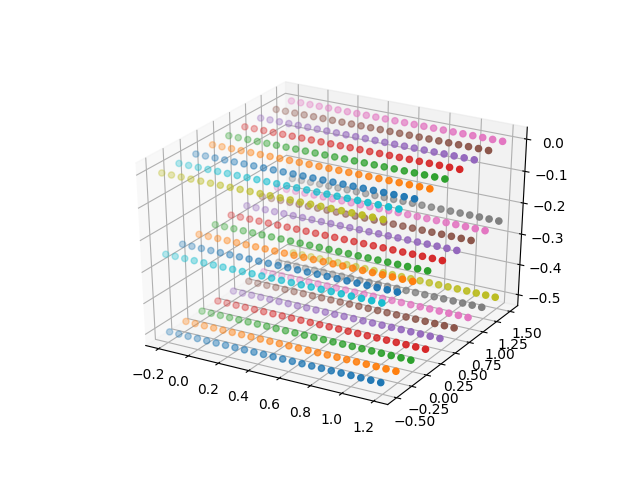

[[<mpl_toolkits.mplot3d.art3d.Path3DCollection at 0xa1d643198>,

In [27]:
#Plot 3d Logical Mesh
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
[[ax.scatter(T[0],np.linspace(T[1][i],T[1][i],len(T[0])),np.linspace(T[2][j],T[2][j],len(T[0]))) for i in range(len(T[1]))]for j in range(3)] 

<IPython.core.display.Javascript object>


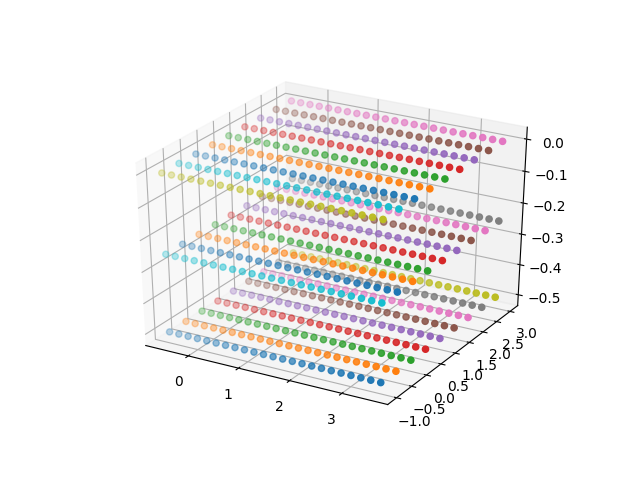

[[<mpl_toolkits.mplot3d.art3d.Path3DCollection at 0xa1d6ea2e8>,

In [28]:
#Physical Mesh 
xp=mapping.f(T[0], T[1], T[2], *args_map, 1)
yp=mapping.f(T[0], T[1], T[2], *args_map, 2)
zp=mapping.f(T[0], T[1], T[2], *args_map, 3)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
[[ax.scatter(xp,np.linspace(yp[i],yp[i],len(xp)),np.linspace(zp[j],zp[j],len(xp))) for i in range(len(yp))]for j in range(3)]

<IPython.core.display.Javascript object>


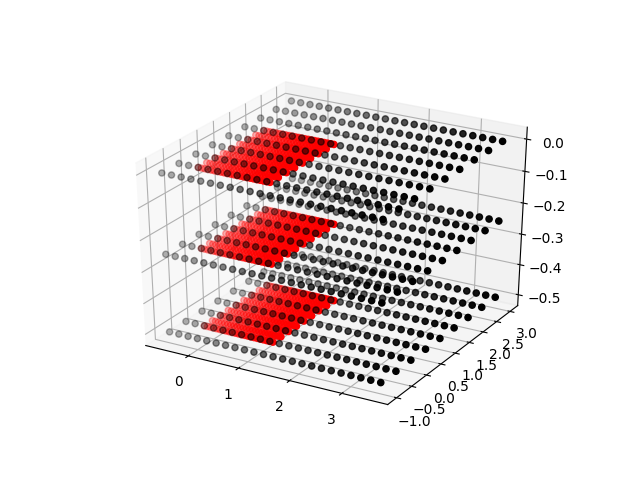

[[<mpl_toolkits.mplot3d.art3d.Path3DCollection at 0xa1d7d32e8>,

In [29]:
#Comparison of Phisical & Logical Mesh, Black is physical mesh
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
[[ax.scatter(xp,np.linspace(yp[i],yp[i],len(xp)),np.linspace(zp[j],zp[j],len(xp)),color='black') for i in range(len(yp))]for j in range(3)]
[[ax.scatter(T[0],np.linspace(T[1][i],T[1][i],len(T[0])),np.linspace(T[2][j],T[2][j],len(T[0])),color='red') for i in range(len(T[1]))]for j in range(3)] 

<IPython.core.display.Javascript object>


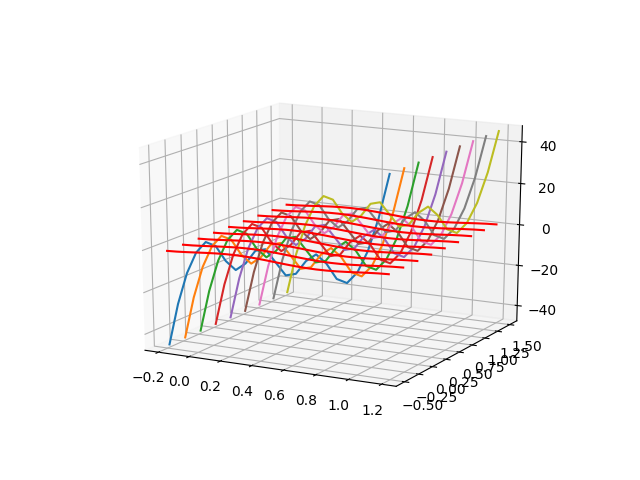

[[<mpl_toolkits.mplot3d.art3d.Line3D at 0xa1d87c828>],

In [30]:
#Physical rho vs V3 projection
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
xp=T[0]
yp=T[1]
zp=T[2]
z=1
def rho_proj(j,z):
    rho=eva.FEM_field_V3_3d(rho_coeff, [xp,yp,zp], T, p, bc)
    return [rho[i][j][z] for i in range(len(xp))]
[ax.plot(xp,np.linspace(yp[j],yp[j],len(xp)),rho_proj(j,z)) for j in range(len(yp))]
[ax.plot(xp,np.linspace(yp[i],yp[i],len(xp)),rho_ini_phys(xp,yp[i],z),color='red') for i in range(len(yp))] 

In [97]:
#Explicit Euler Integration
k0=p[0]
k1=p[1]
k2=p[2]
x=np.linspace(0,1,100)
y=np.linspace(0,1,100)
z=np.array([0])
#rho_0_plot=eva.FEM_field_V3_3d(rho_coeff, [T[0][k0:-(k0+1)],T[1][k1:-(k1+1)],T[2][k2:-(k2+1)]], T, p, bc)
rho_0_plot=eva.FEM_field_V3_3d(rho_coeff, [x,y,z], T, p, bc)
#def rho_t1 (rho_0,rho_t,dt):
#    return rho_0+dt*rho_t
#rhot11=rho_coeff+5*rho_t

In [100]:
z_r=np.array([[rho_0_plot[i][j][0] for i in range(100)]for j in range(100)])

<IPython.core.display.Javascript object>


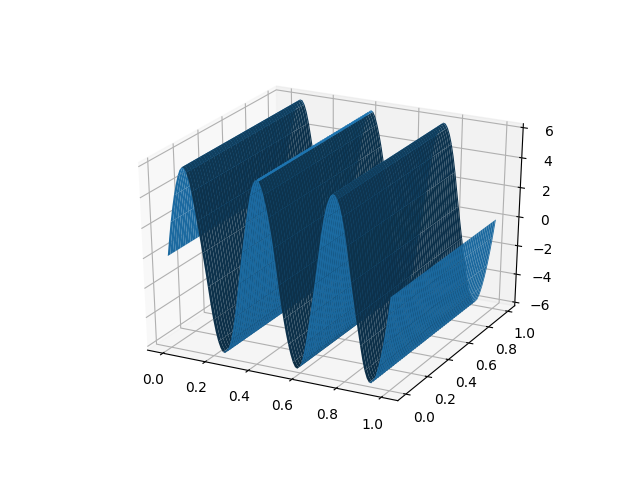

In [105]:
x_m, y_m=np.meshgrid(x,y)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x_m,y_m,z_r)

<IPython.core.display.Javascript object>


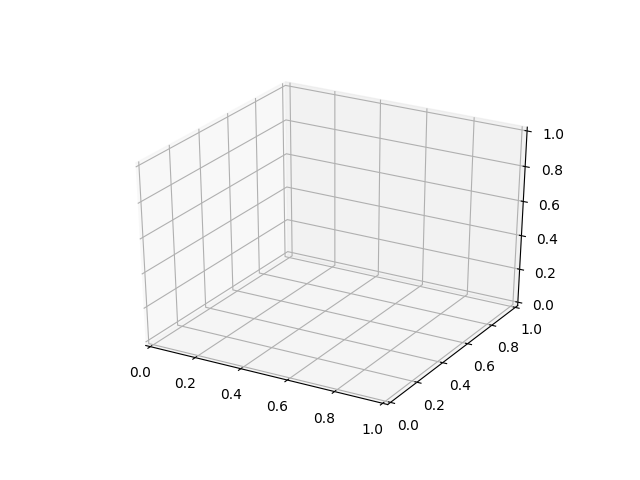

ValueError: input operand has more dimensions than allowed by the axis remapping

In [63]:
xp=T[0][k0:-(k0+1)]
yp=T[1][k1:-(k1+1)]
zp=T[2][k2:-(k2+1)]
def rho_plot(j,z):
    return [rho_0_plot[i][j][z] for i in range(len(rho_0_plot[0]))]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
[ax.plot(xp,np.linspace(x[j],y[j],len(x)),rho_proj(j,z),color='red') for j in range(1)]
#[ax.plot(xp,np.linspace(yp[j],yp[j],len(xp)),rho_plot(j,z),color='black') for j in range(1)]